In [1]:
import numpy as np
import pandas as pd
import gcp.bigquery as bq
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
%%sql --module ha

DEFINE query totals
SELECT 
  rank as RANK,
  INTEGER(bytesTotal/1024) as TOTAL, 
  INTEGER(bytesHtml/1024)  as HTML,
  INTEGER(bytesJS/1024)    as JS,
  INTEGER(bytesCSS/1024)   as CSS, 
  INTEGER(bytesImg/1024)   as IMG,
  INTEGER(bytesFont/1024)  as FONT,
  INTEGER(bytesFlash/1024) as FLASH, 
  INTEGER(bytesJson/1024)  as JSON,
  INTEGER(bytesOther/1024)
  + INTEGER(bytesVideo/1024) 
  + INTEGER(bytesAudio/1024) as OTHER
FROM $table

DEFINE query old_schema_totals
SELECT 
  rank as RANK,
  INTEGER(bytesTotal/1024) as TOTAL, 
  INTEGER(bytesHtml/1024)  as HTML,
  INTEGER(bytesJS/1024)    as JS,
  INTEGER(bytesCSS/1024)   as CSS, 
  INTEGER(bytesImg/1024)   as IMG,
  INTEGER(bytesFont/1024)  as FONT,
  INTEGER(bytesFlash/1024) as FLASH, 
  INTEGER(bytesJson/1024)  as JSON,
  INTEGER(bytesOther/1024) as OTHER
FROM $table

In [3]:
desktop = {}
mobile = {}

In [4]:
def show(data, metric, title='', trim=1.0, rank=float('inf')):
  if metric == 'rank':
    return
  
  data = data[data['rank'] < rank]
  max = int(data[metric].quantile(trim))
  if max == 0:
    return

  plt.figure(figsize=(10, 3))
  gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])

  plt.subplot(gs[0])
  plt.hist([data[metric]], bins=50, alpha=0.6, range=(0,max))
  plt.title(title)
  plt.xlabel('KB')    
  plt.yticks([])
  plt.xticks(rotation=30)

  q1 = int(data[metric].quantile(0.25))
  q2 = int(data[metric].quantile(0.50))
  q3 = int(data[metric].quantile(0.75))
  mean = int(data[metric].mean())

  plt.axvline(q1, color='r', linestyle='dashed', linewidth=2)
  plt.axvline(q2, color='b', linestyle='solid', linewidth=2)
  plt.axvline(q3, color='r', linestyle='dashed', linewidth=2)
  plt.axvline(mean, color='g', linestyle='dotted', linewidth=2)

  plt.legend((
      '25th: {0} KB'.format(q1),
      '50th: {0} KB'.format(q2),
      '75th: {0} KB'.format(q3),
      'mean: {0} KB'.format(mean)
    ), loc='best')

  plt.subplot(gs[1])
  plt.title("CDF")
  series = pd.Series(data[metric])
  cumdist = np.linspace(0., 1., len(series))
  cdf = pd.Series(cumdist, index=series.order())
  ax = cdf.plot()

  ax.locator_params(axis='y', nbins=10)
  ax.locator_params(axis='x', nbins=10, tight=True)
  ax.set_xlim(0, data[metric].quantile(trim))
  
  plt.xticks(rotation=30)
  plt.xlabel('KB')

  plt.tight_layout()

## Desktop stats

In [5]:
id = bq.Table('httparchive:runs.2015_12_01_pages')
desktop['2015'] = bq.Query(ha.totals, table = id).to_dataframe()

In [6]:
id = bq.Table('httparchive:runs.2014_12_01_pages')
desktop['2014'] = bq.Query(ha.old_schema_totals, table = id).to_dataframe()

In [21]:
id = bq.Table('httparchive:runs.2013_12_15_pages')
desktop['2013'] = bq.Query(ha.old_schema_totals, table = id).to_dataframe()

In [8]:
id = bq.Table('httparchive:runs.2012_12_01_pages')
desktop['2012'] = bq.Query(ha.old_schema_totals, table = id).to_dataframe()

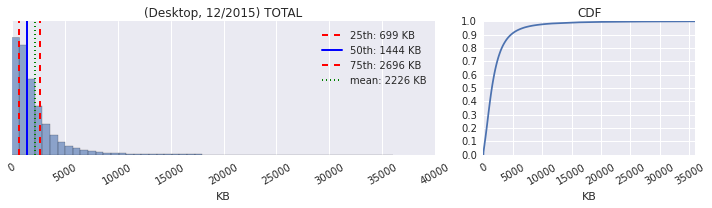

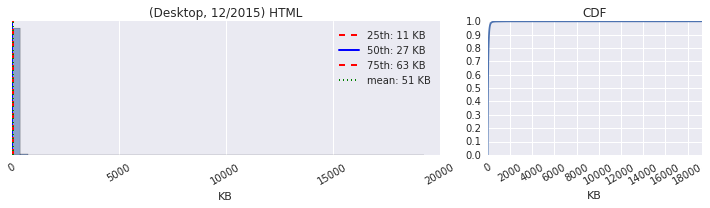

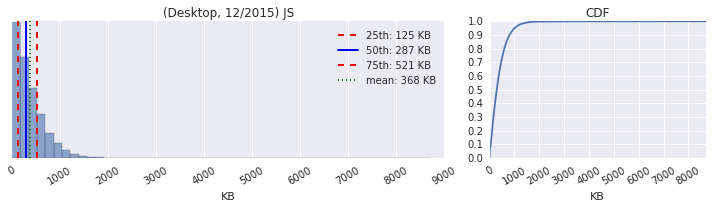

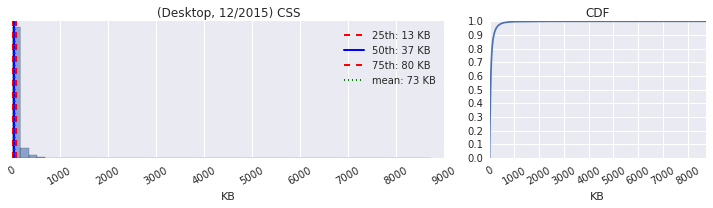

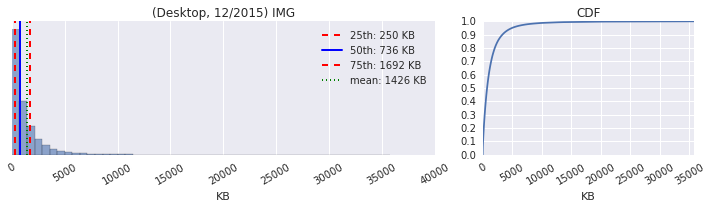

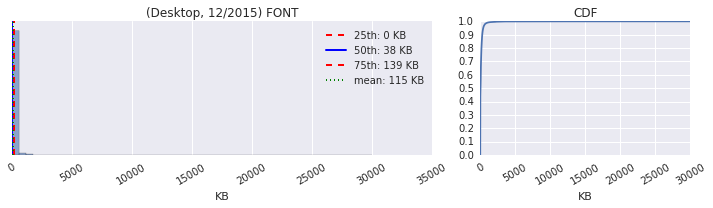

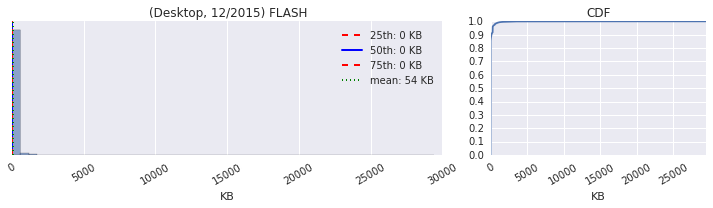

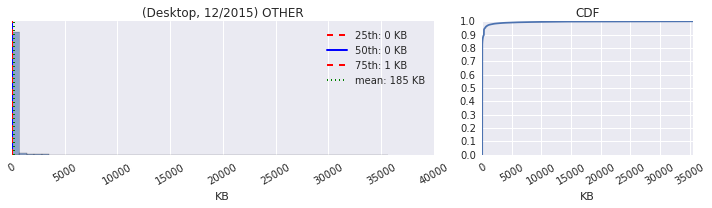

In [13]:
for column in desktop['2015']:
  show(desktop['2015'], column, '(Desktop, 12/2015) '+column, trim=1.0)

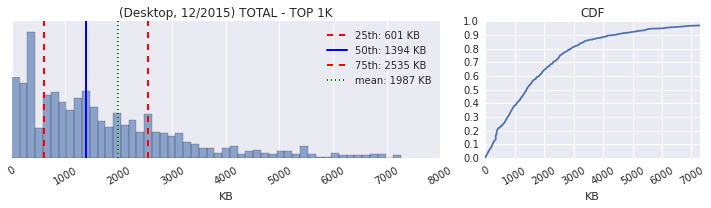

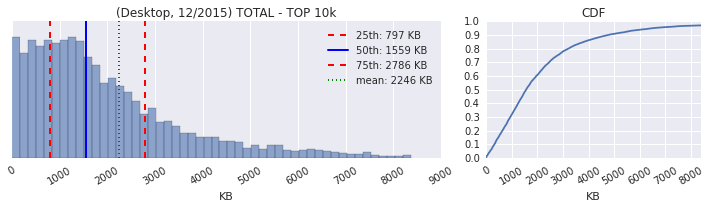

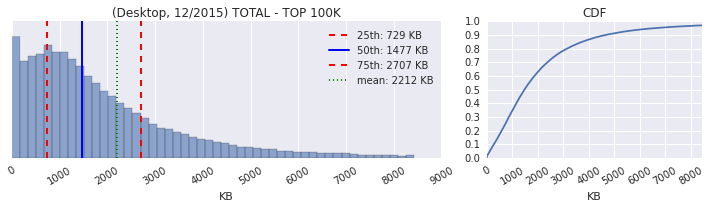

In [14]:
column = 'TOTAL'
show(desktop['2015'], column, '(Desktop, 12/2015) '+column+' - TOP 1K', trim=0.97, rank=1000)
show(desktop['2015'], column, '(Desktop, 12/2015) '+column+' - TOP 10k', trim=0.97, rank=10000)
show(desktop['2015'], column, '(Desktop, 12/2015) '+column+' - TOP 100K', trim=0.97, rank=100000)

## Mobile stats

In [9]:
id = bq.Table('httparchive:runs.2015_12_01_pages_mobile')
mobile['2015'] = bq.Query(ha.totals, table = id).to_dataframe()

In [10]:
id = bq.Table('httparchive:runs.2014_12_01_pages_mobile')
mobile['2014'] = bq.Query(ha.old_schema_totals, table = id).to_dataframe()

In [11]:
id = bq.Table('httparchive:runs.2013_12_15_pages_mobile')
mobile['2013'] = bq.Query(ha.old_schema_totals, table = id).to_dataframe()

In [12]:
id = bq.Table('httparchive:runs.2012_12_15_pages_mobile')
mobile['2012'] = bq.Query(ha.old_schema_totals, table = id).to_dataframe()

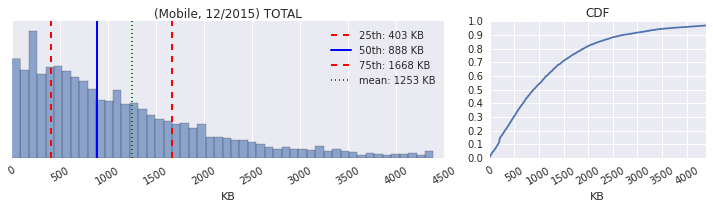

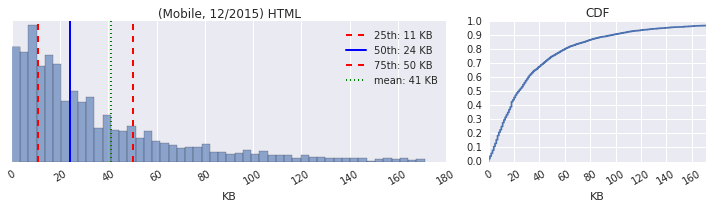

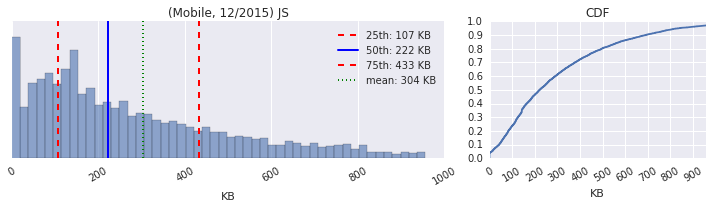

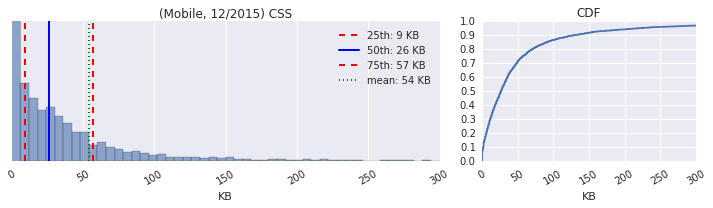

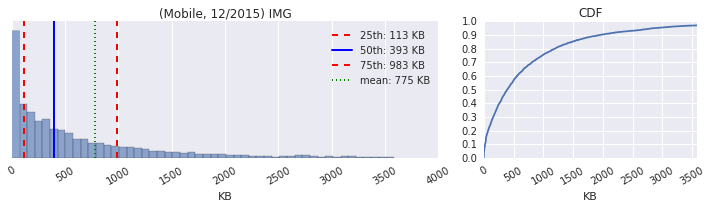

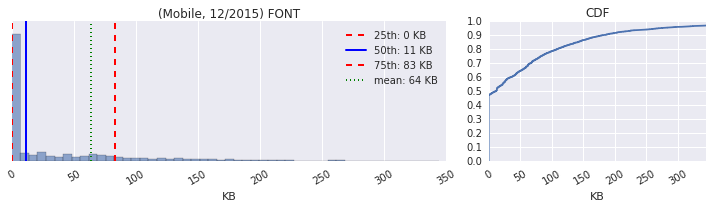

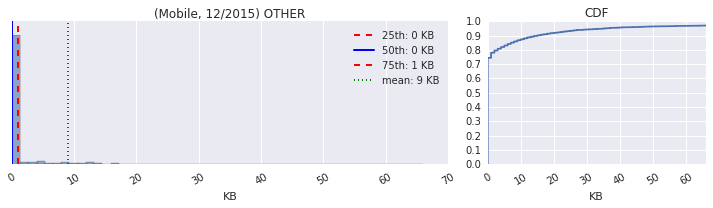

In [15]:
for column in mobile['2015']:
  show(mobile['2015'], column, '(Mobile, 12/2015) '+column, trim=0.97)

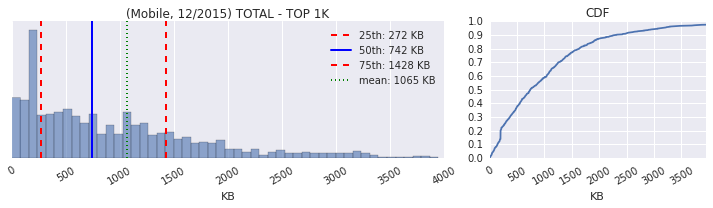

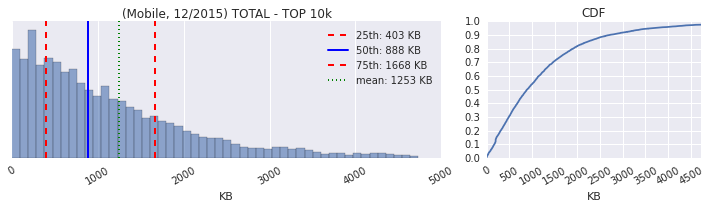

In [16]:
column = 'TOTAL'
show(mobile['2015'], column, '(Mobile, 12/2015) '+column+' - TOP 1K', trim=0.975, rank=1000)
show(mobile['2015'], column, '(Mobile, 12/2015) '+column+' - TOP 10k', trim=0.975, rank=10000)

# CDFs

In [40]:
def cdfs(data, trim=1.0, title='', rank=float('inf')):
  fig = plt.figure(figsize=(10, 10))
  fig.suptitle(title, fontsize=17)
  gs = gridspec.GridSpec(5, 2, height_ratios=[1.5,1,1,1,1])
  gs_idx = 1

  def plot_cdf(col, year, xbins=20, ybins=10):
    cumdist = np.linspace(0., 1., len(col))
    cdf = pd.Series(cumdist, index=col.order())
    
    ax = cdf.plot(label=year)
    ax.locator_params(axis='y', nbins=ybins, tight=True)
    ax.locator_params(axis='x', nbins=xbins, tight=True)
    ax.set_xlim(0, int(col.quantile(trim)))
    plt.xticks(rotation=60)
    plt.xlabel('')    

  for metric in ("TOTAL", "HTML", "IMG", "JS", "CSS", "FONT", "OTHER"): 
    for year, df in data.iteritems():
      df = df[df['rank'] < rank]
      if metric == 'TOTAL':
        plt.subplot(gs[0, :])
        plot_cdf(df[metric], year, xbins=40)
      else:
        ax = plt.subplot(gs[gs_idx])
        plot_cdf(df[metric], year, ybins=5)
        
      plt.title(metric)
    gs_idx += 1

  plt.legend(loc='center', bbox_to_anchor=(0, -0.75),
          ncol=5, fontsize='x-large')  
  gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

## Desktop CDF's

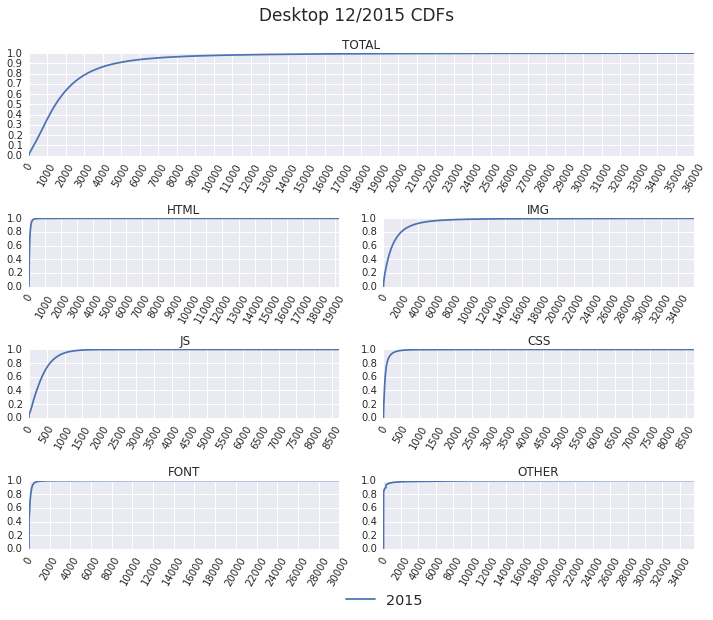

In [45]:
cdfs({2015: desktop['2015']}, trim=1.0, title='Desktop 12/2015 CDFs')

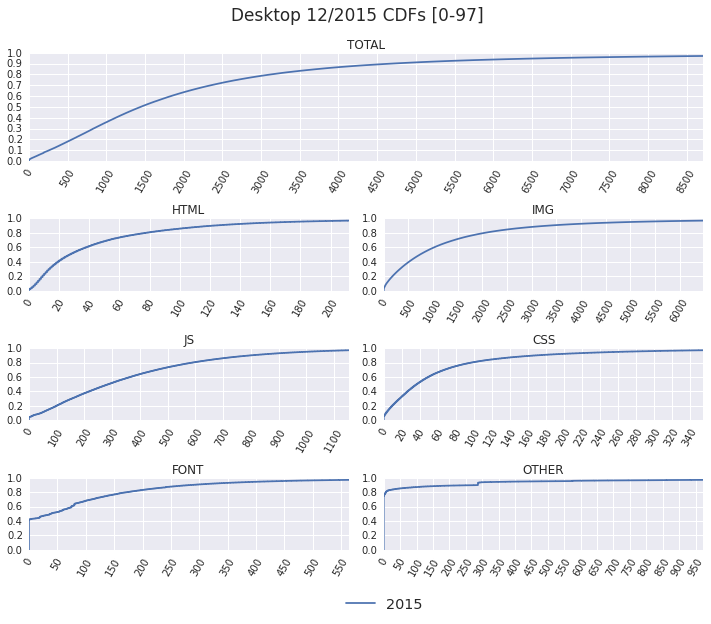

In [46]:
cdfs({2015: desktop['2015']}, trim=0.97, title='Desktop 12/2015 CDFs [0-97]')

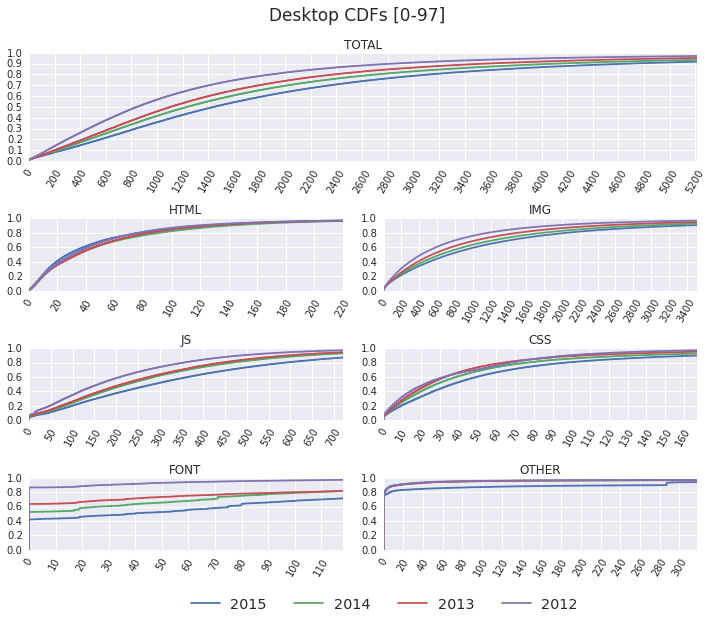

In [47]:
cdfs(desktop, trim=0.97, title='Desktop CDFs [0-97]')

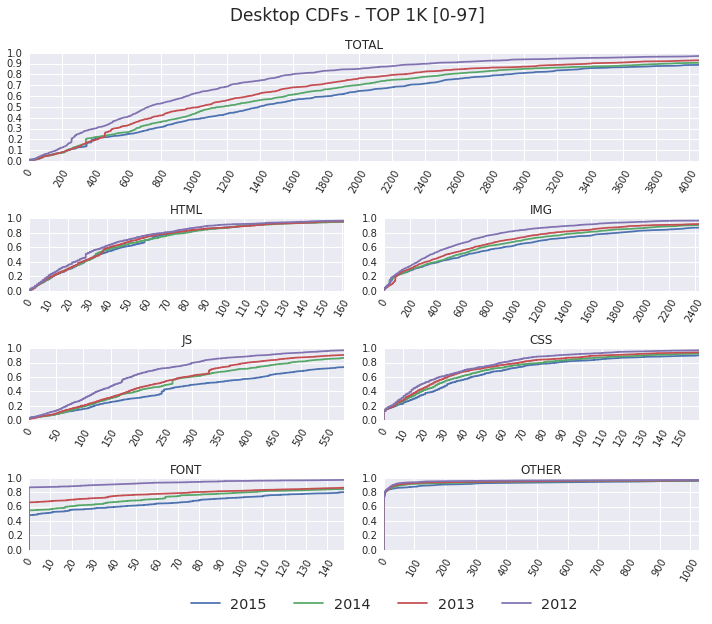

In [49]:
cdfs(desktop, trim=0.97, rank=1000, title='Desktop CDFs - TOP 1K [0-97]')

## Mobile CDF's

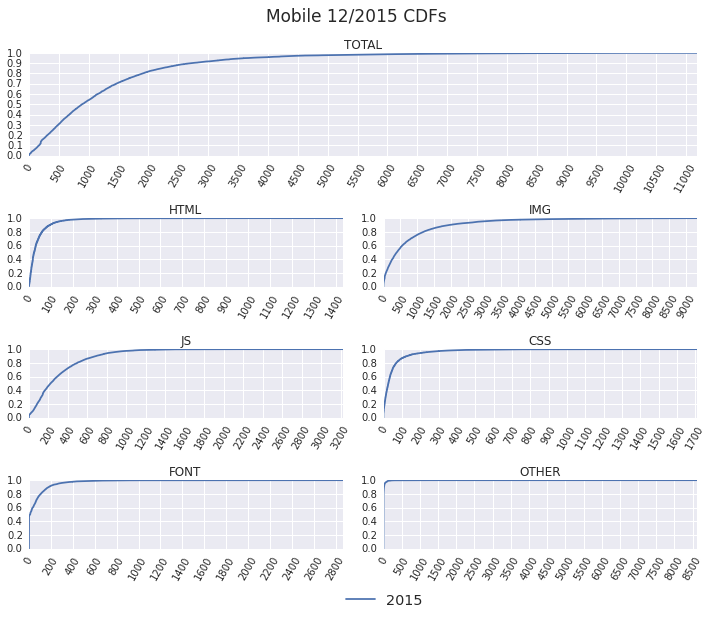

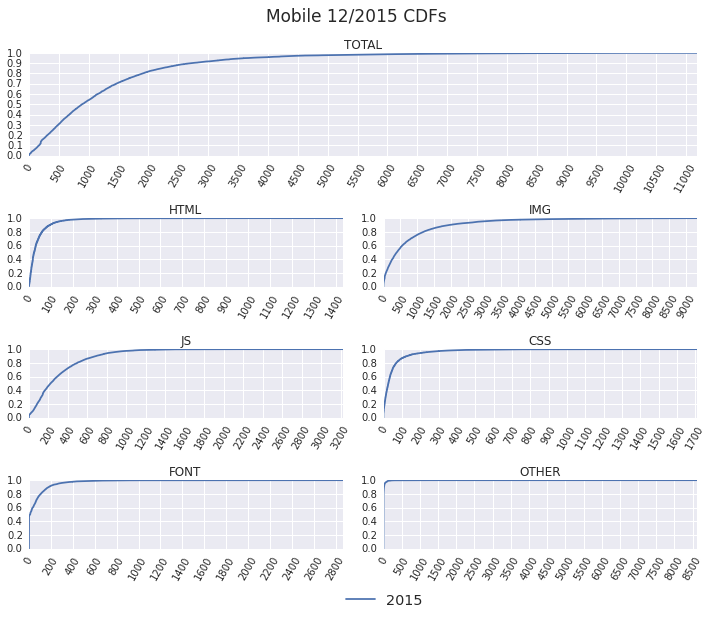

In [64]:
cdfs({2015: mobile['2015']}, trim=1.0, title='Mobile 12/2015 CDFs')

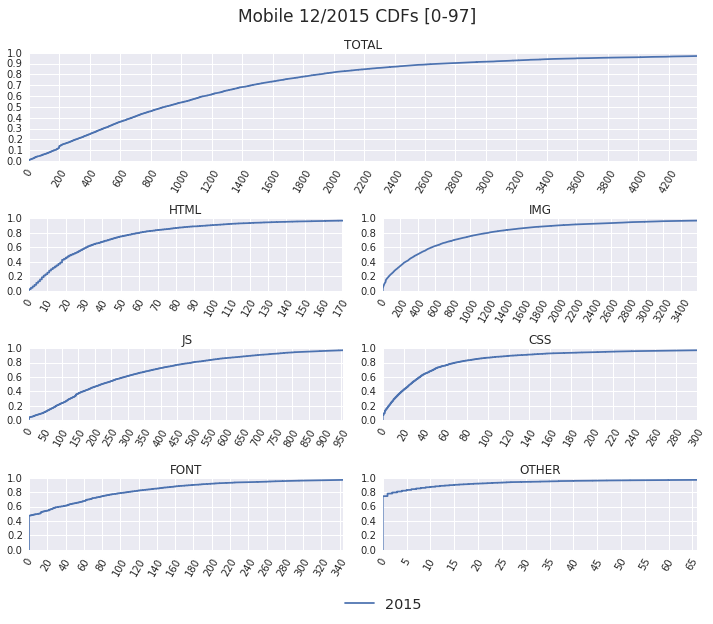

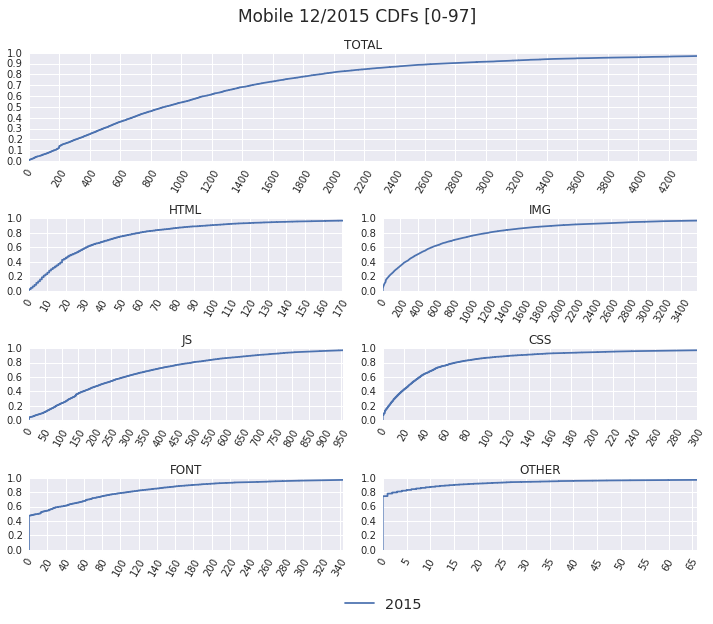

In [65]:
cdfs({2015: mobile['2015']}, trim=0.97, title='Mobile 12/2015 CDFs [0-97]')

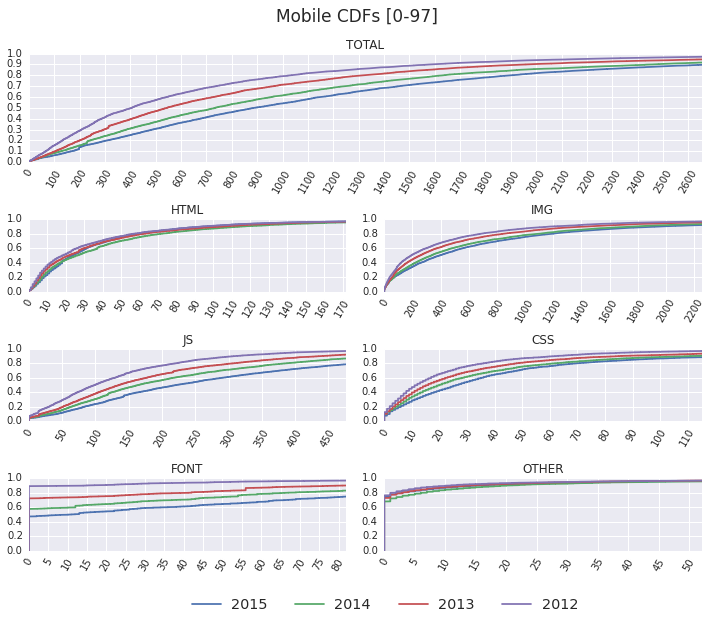

In [53]:
cdfs(mobile, trim=0.97, title='Mobile CDFs [0-97]')

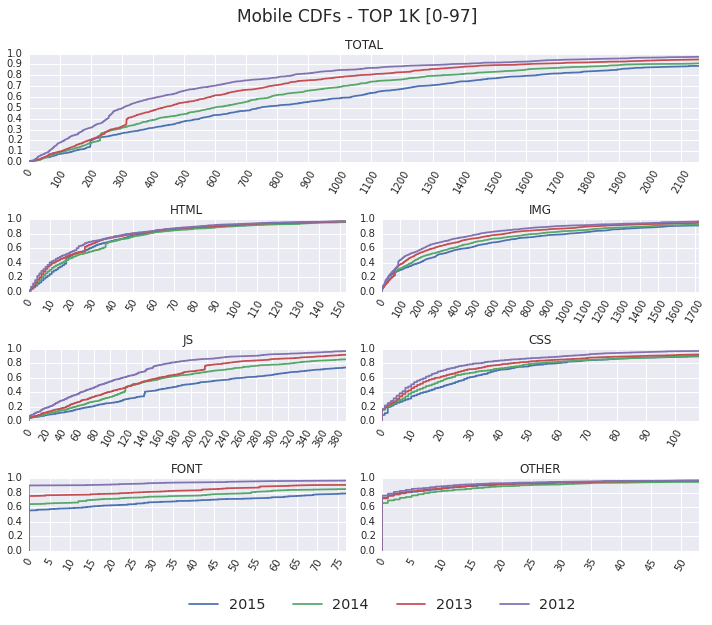

In [54]:
cdfs(mobile, trim=0.97, rank=1000, title='Mobile CDFs - TOP 1K [0-97]')

## Compare

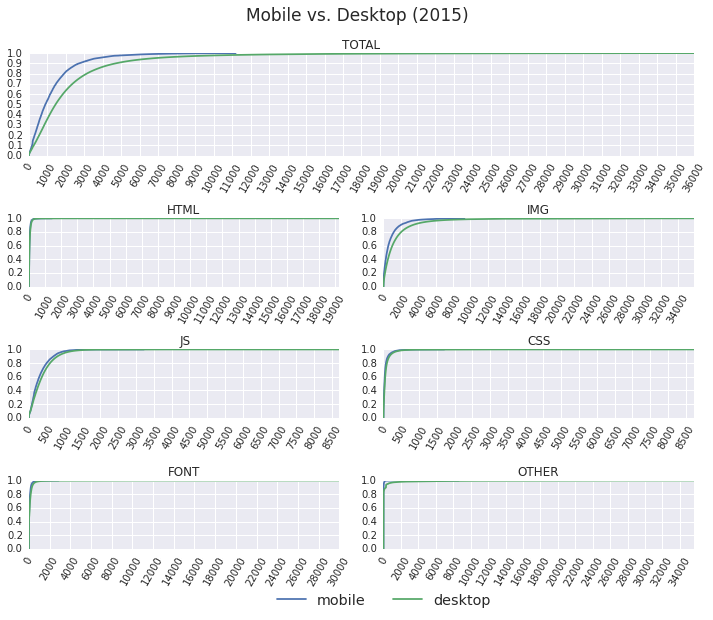

In [44]:
cdfs({'mobile': mobile['2015'], 'desktop': desktop['2015']}, trim=1.0, 
     title='Mobile vs. Desktop (2015)')

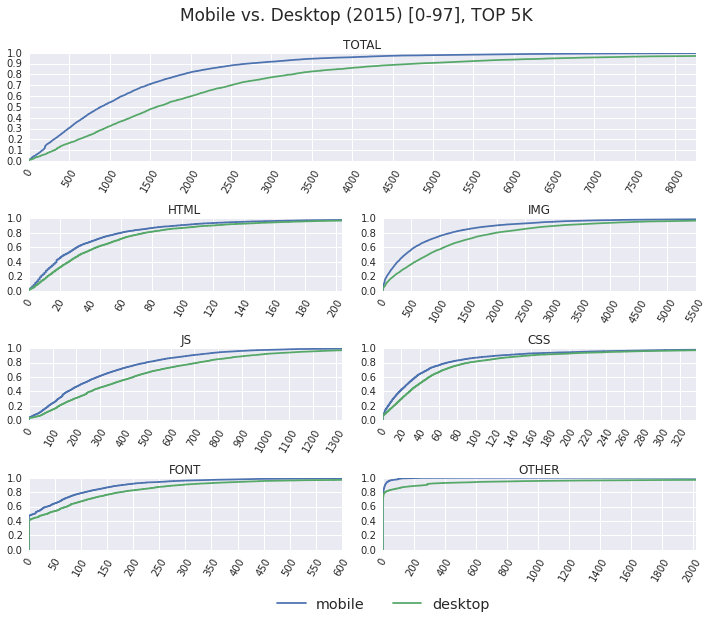

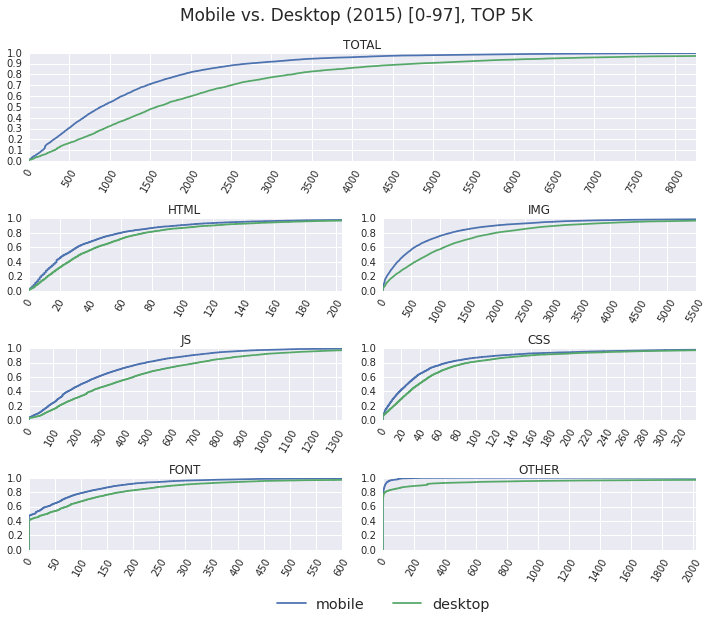

In [66]:
cdfs({'mobile': mobile['2015'], 'desktop': desktop['2015']}, trim=0.97, 
     title='Mobile vs. Desktop (2015) [0-97], TOP 5K', rank=5000)

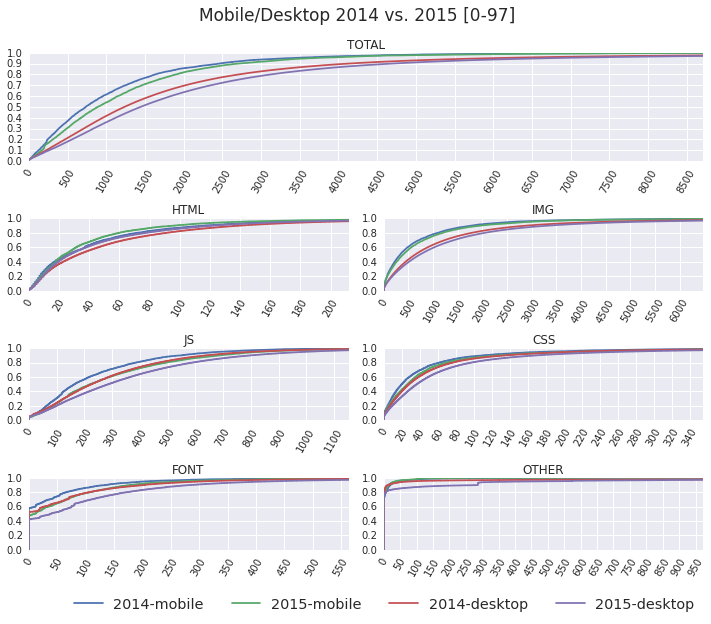

In [51]:
cdfs({
  '2015-mobile': mobile['2015'], '2015-desktop': desktop['2015'],
  '2014-mobile': mobile['2014'], '2014-desktop': desktop['2014']}, 
     trim=0.97, title='Mobile/Desktop 2014 vs. 2015 [0-97]')

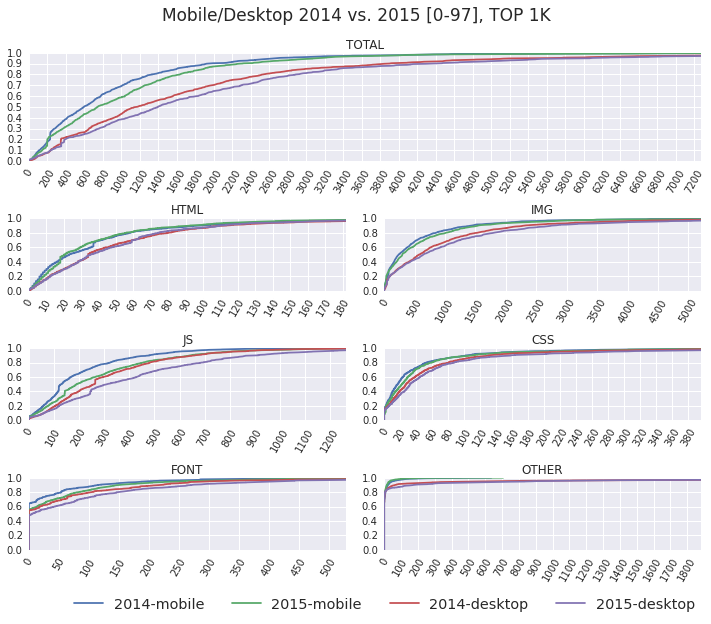

In [55]:
cdfs({
  '2015-mobile': mobile['2015'], '2015-desktop': desktop['2015'],
  '2014-mobile': mobile['2014'], '2014-desktop': desktop['2014']}, 
     trim=0.97, rank=1000, title='Mobile/Desktop 2014 vs. 2015 [0-97], TOP 1K')